In [1]:
import pandas as pd
import seaborn as sns
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from itertools import combinations
import scipy.stats
import itertools
import stats

In [ ]:
model_dir = "/scratch4/mdredze1/icachol1/readability_analysis-models/"
data_dir =  "/scratch4/mdredze1/icachol1/readability_analysis-data/"

In [3]:
survey_df = pd.read_csv(model_dir + 'df_post_survey_all.csv')
survey_df.columns

Index(['Unnamed: 0', 'uuid', 'science_interest', 'age', 'gender', 'retake',
       'language', 'education', 'stemEducation', 'researchInvolved', 'id',
       'timestamp', 'data_type', 'valuable_info', 'comprehensionQ1',
       'comprehensionQ2', 'article_interest', 'article_read_ease',
       'valuable_info_text', 'article_understanding', 'article_familiar',
       'complexityLevel', 'order', 'paperId', 'stemEducationMapped',
       'eduMapped', 'relevantInterest', 'isHighStem', 'study',
       'generated_free_text', 'generated_text_check'],
      dtype='object')

In [ ]:
scipy.stats.pearsonr(survey_df['article_familiar'], survey_df['article_read_ease'])

PearsonRResult(statistic=0.3184914338843462, pvalue=3.1605332427185968e-43)

In [ ]:
scipy.stats.pearsonr(survey_df['stemEducationMapped'], survey_df['article_read_ease'])

PearsonRResult(statistic=0.021857721310244653, pvalue=0.35685139944411404)

In [37]:
survey_df['article_read_ease'].value_counts() / sum(survey_df['article_read_ease'].value_counts())

article_read_ease
5    0.366498
4    0.298482
3    0.167510
2    0.101180
1    0.066329
Name: count, dtype: float64

<Axes: xlabel='article_read_ease', ylabel='Count'>

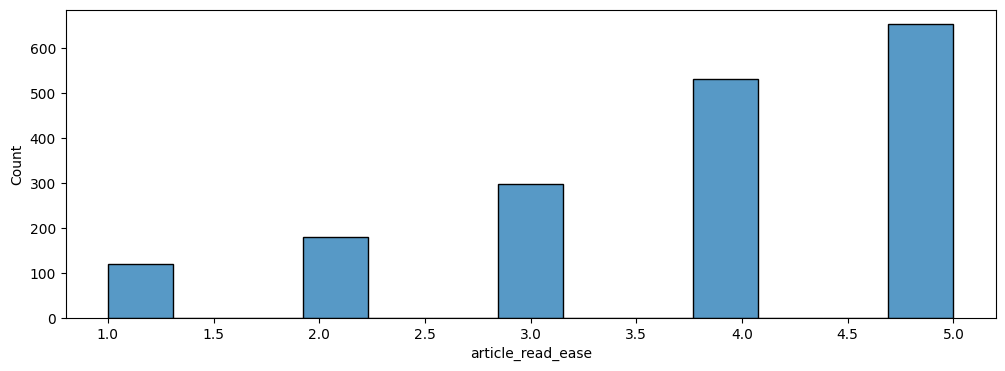

In [35]:
sns.histplot(survey_df['article_read_ease'])

In [6]:
metric_names = [
          "coleman_liau",
           "dale_chall",
           "gunning_fog",
          "flesch",
           "spache",
           "ari",
           "linsear_write",
           ]
def get_readability_metrics(text):
  r = Readability(text)
  scores = {}
  for m_name in metric_names:
    f = getattr(r, m_name)
    try:
      scores[m_name] = f().score
    except:
      scores[m_name] = -1
  return scores
text = """
  In linguistics, the Gunning fog index is a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading. For instance, a fog index of 12 requires the reading level of a United States high school senior (around 18 years old). The test was developed in 1952 by Robert Gunning, an American businessman who had been involved in newspaper and textbook publishing.
  The fog index is commonly used to confirm that text can be read easily by the intended audience. Texts for a wide audience generally need a fog index less than 12. Texts requiring near-universal understanding generally need an index less than 8.
  """
get_readability_metrics(text)

{'coleman_liau': 10.673162393162393,
 'dale_chall': 9.32399010989011,
 'gunning_fog': 12.4976800976801,
 'flesch': 51.039230769230784,
 'spache': 7.164945054945054,
 'ari': 9.551245421245422,
 'linsear_write': 11.214285714285714}

In [7]:
clean_summ_df = pd.read_csv(model_dir + "cleaned_summaries.csv")
clean_summ_df.head()

,name,textVersion,studyName,studyNum,cleanText,r-flesch_kincaid,r-gunning_fog,r-coleman_liau,r-dale_chall,r-ari,r-linsear_write,r-spache,s-article_read_ease,s-article_understanding,s-article_interest,s-valuable_info
0,redditCommentsARDS,Low,text_expert (Study 1),1,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,4.043478,3.739130,3.478261,4.086957
1,redditCommentsARDS,Low,text_expert (Study 1),2,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,4.250000,3.958333,4.208333,4.208333
2,redditCommentsARDS,Low,text_expert (Study 1),3,Scientists create a device which can detect th...,14.942389,18.585356,12.726358,11.273107,16.659181,19.500000,8.732246,3.157895,3.368421,3.105263,3.947368
3,redditCommentsARDS,Low,text_gpt3 (Study 2),1,"\r\n\r\nWhen someone has a lung problem, docto...",8.867698,11.420317,8.966870,7.890558,9.662152,11.769231,5.945578,4.043478,3.739130,3.478261,4.086957
4,redditCommentsARDS,Low,text_gpt3 (Study 2),2,"\r\n\r\nWhen someone has a lung problem, docto...",8.867698,11.420317,8.966870,7.890558,9.662152,11.769231,5.945578,4.250000,3.958333,4.208333,4.208333


In [8]:
scores = clean_summ_df["cleanText"].apply(get_readability_metrics)
for m_name in metric_names:
  m_scores = scores.apply(lambda r: r[m_name])
  clean_summ_df[f"r-{m_name}"] = m_scores

In [ ]:
def read_model_outputs(model_name, prompt_num):
    tmp = pd.read_csv(model_dir + f"{model_name}-prompt{prompt_num}.csv")
    sub_name = model_name.split("/")[1]
    clean_summ_df[f"r-{sub_name}_prompt{prompt_num}"] = tmp['reading_ease']

In [10]:
## Llama-3.1-8B-Instruct
read_model_outputs("meta-llama/Llama-3.1-8B-Instruct", 1)
## Llama-3.1-8B-Instruct - prompt with demographics
read_model_outputs("meta-llama/Llama-3.1-8B-Instruct", 2)
## Llama-3.1-8B-Instruct - prompt with topic familiarity
read_model_outputs("meta-llama/Llama-3.1-8B-Instruct", 3)
read_model_outputs("meta-llama/Llama-3.1-8B-Instruct", 4)

In [11]:
# Llama-3.3-70B-Instruct
read_model_outputs("meta-llama/Llama-3.3-70B-Instruct", 1)
read_model_outputs("meta-llama/Llama-3.3-70B-Instruct", 2)
read_model_outputs("meta-llama/Llama-3.3-70B-Instruct", 3)
read_model_outputs("meta-llama/Llama-3.3-70B-Instruct", 4)

In [ ]:
# Mistral AI
read_model_outputs("mistralai/Mistral-7B-Instruct-v0.3", 4)
read_model_outputs("mistralai/Mixtral-8x7B-Instruct-v0.1", 4)

In [13]:
#OlMo 
read_model_outputs("allenai/OLMo-2-1124-7B-Instruct", 4)
read_model_outputs("allenai/OLMo-2-1124-13B-Instruct", 4)

In [14]:
## gemma-7b-it - simple prompt
read_model_outputs("google/gemma-7b-it", 1)
read_model_outputs("google/gemma-7b-it", 4)

In [ ]:
all_model_names =  [
                    "OLMo-2-1124-7B-Instruct_prompt4",
                    "OLMo-2-1124-13B-Instruct_prompt4",
                    # 'Llama-3.1-8B-Instruct-prompt1',
                    # 'Llama-3.1-8B-Instruct-prompt2',
                    # 'Llama-3.1-8B-Instruct-prompt3',
                    # 'gemma-7b-it-prompt1',
                    "Mistral-7B-Instruct-v0.3_prompt4",
                    'gemma-7b-it_prompt4',
                    "Mixtral-8x7B-Instruct-v0.1_prompt4",
                    # 'llama_33_70b_instruct_prompt1',
                    # 'llama_33_70b_instruct_prompt2',
                    # 'llama_33_70b_instruct_prompt3',
                    'Llama-3.1-8B-Instruct_prompt4',
                    'Llama-3.3-70B-Instruct_prompt4',
                    ]

In [ ]:
clean_summ_df['r-flesch_kincaid']

0      14.942389
1      14.942389
2      14.942389
3       8.867698
4       8.867698
         ...    
175    11.806482
176    11.806482
177    15.497939
178    15.497939
179    15.497939
Name: r-flesch_kincaid, Length: 180, dtype: float64

In [17]:
max(clean_summ_df['r-flesch_kincaid'])

21.845028121484813

In [ ]:
fkgl_binary = clean_summ_df['r-flesch_kincaid'] > 30
sum(fkgl_binary) / len(fkgl_binary)

0.0

In [ ]:
lm_binary = clean_summ_df['r-Llama-3.3-70B-Instruct_prompt4'] > 3
sum(lm_binary)/ len(lm_binary)

0.6888888888888889

In [20]:
all_paper_names = clean_summ_df["name"].unique()
text_versions = clean_summ_df["textVersion"].unique()
study_names = ['text_expert (Study 1)', 'text_gpt3 (Study 2)', 'text_gpt3.5 (Study 3)']
study_num = [1,2,3]
all_summary_types = list(itertools.product(all_paper_names, text_versions, study_names, study_num))

In [21]:
def get_mean_attr_value(df, paper_name, text_version, study, attr):
  tmp = df[df['paperId']==paper_name]
  tmp = tmp[tmp['study']==study]
  tmp = tmp[tmp['complexityLevel']==text_version]
  return tmp[attr].mean()

avg_attr_values = {}
attr_names = ['article_read_ease','article_understanding', 'article_interest', 'valuable_info']
for attr_name in attr_names:
  this_attr = []
  for paper_name, t_version, _, study_num in all_summary_types:
    mean_attr = get_mean_attr_value(survey_df, paper_name, t_version, study_num, attr_name)
    this_attr.append(mean_attr)
  clean_summ_df[f"s-{attr_name}"] = this_attr

In [22]:
# scipy.stats.pearsonr()
tmp = clean_summ_df[[f"r-Llama-3.3-70B-Instruct_prompt4", f"s-article_read_ease"]]
x = tmp.iloc[:,0]
y = tmp.iloc[:,1]
pearson = scipy.stats.pearsonr(x,y)
stat = pearson.statistic
print(stat)
pearson.confidence_interval()

0.5139929706479224


ConfidenceInterval(low=0.3976222231314377, high=0.6140900326096687)

In [23]:
all_metric_names = metric_names + all_model_names
attr_metric_combos = list(itertools.product(all_metric_names, attr_names))
all_correlations_pearson = np.zeros((len(all_metric_names), len(attr_names)))
all_correlations_kt = np.zeros((len(all_metric_names), len(attr_names)))
err = np.empty_like(all_correlations_pearson)
neg_metrics = ["coleman_liau", "dale_chall", "gunning_fog", "spache","ari"]
for m_idx, metric_name in enumerate(all_metric_names):
  for a_idx, attr_name in enumerate(attr_names):
    tmp = clean_summ_df[[f"r-{metric_name}", f"s-{attr_name}"]]
    if metric_name in neg_metrics:
      tmp[f"r-{metric_name}"] *= -1
    pearson = scipy.stats.pearsonr(tmp.iloc[:,0],tmp.iloc[:,1])
    kendall = scipy.stats.kendalltau(tmp.iloc[:,0],tmp.iloc[:,1])
    all_correlations_pearson[m_idx, a_idx] = pearson.statistic
    all_correlations_kt[m_idx, a_idx] = kendall.statistic
    err[m_idx, a_idx] = pearson.pvalue < 0.05
print(all_correlations_pearson)
print(all_correlations_kt)

[[ 0.32427753  0.23142632  0.11776138  0.10524763]
 [ 0.30564962  0.21476968  0.15420732  0.0621083 ]
 [ 0.21132191  0.11978486  0.05198998  0.0409602 ]
 [ 0.26222167  0.16141035  0.09080471  0.05562457]
 [ 0.11876415  0.03686929 -0.00221843 -0.03597998]
 [ 0.1124973   0.02583694 -0.00771816 -0.01662337]
 [-0.07339127  0.01018588  0.01846753  0.02995054]
 [ 0.01370309 -0.01364177  0.02916257  0.02345986]
 [ 0.20351295  0.18269704  0.03094697  0.01214805]
 [ 0.34857867  0.34334787  0.16065604  0.12798274]
 [ 0.35376363  0.34514446  0.07122419  0.06468613]
 [ 0.39855951  0.33430453  0.11682198  0.10977894]
 [ 0.49038033  0.48733582  0.26961226  0.24712175]
 [ 0.51399297  0.46383594  0.18148633  0.17543205]]
[[ 0.20211174  0.11644252  0.06106872  0.02778617]
 [ 0.21367535  0.1429354   0.10127858 -0.00315752]
 [ 0.13750637  0.05916743  0.01922534  0.0005052 ]
 [ 0.15975375  0.07619857  0.04222035  0.00265232]
 [ 0.06812473  0.00643399 -0.02236673 -0.05999286]
 [ 0.07013579  0.00037847 -0.0

/tmp/ipykernel_3958301/2301268576.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[f"r-{metric_name}"] *= -1
/tmp/ipykernel_3958301/2301268576.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[f"r-{metric_name}"] *= -1
/tmp/ipykernel_3958301/2301268576.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

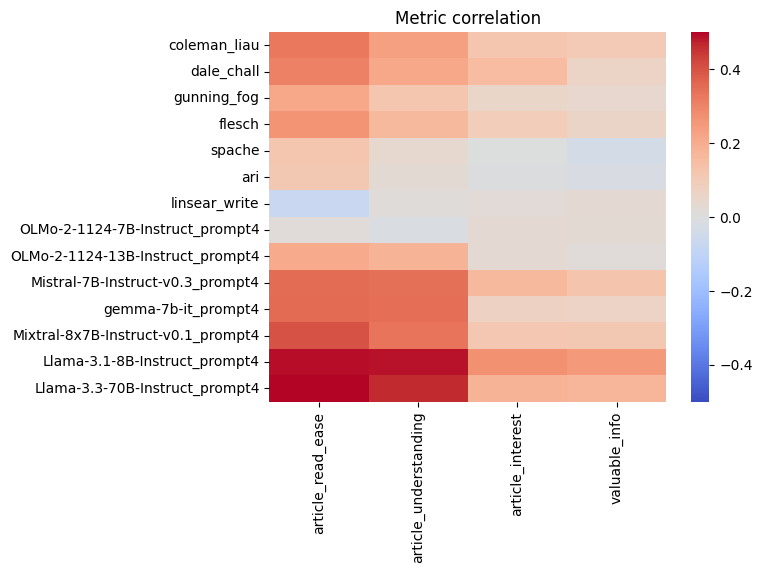

In [24]:
sns.heatmap(all_correlations_pearson, cmap='coolwarm', xticklabels=attr_names, yticklabels=all_metric_names, vmin=-0.5,vmax=0.5)
plt.title("Metric correlation")
plt.show()

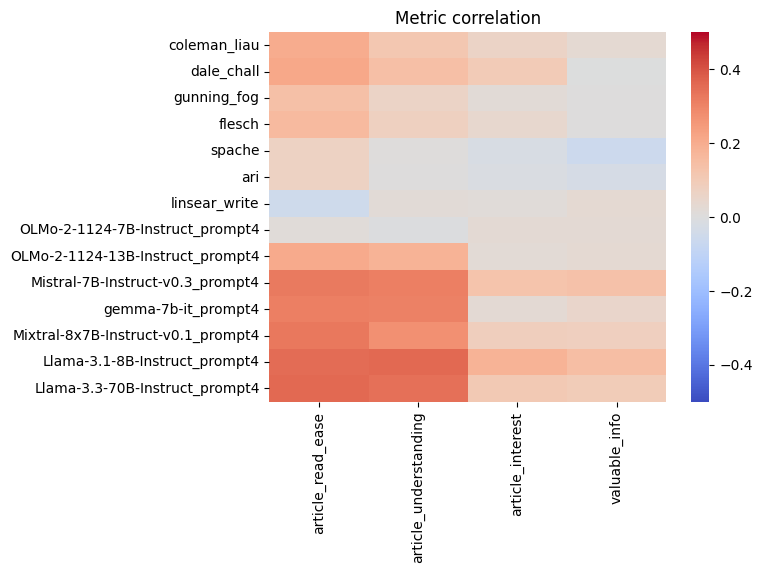

In [25]:
sns.heatmap(all_correlations_kt, cmap='coolwarm', xticklabels=attr_names, yticklabels=all_metric_names, vmin=-0.5,vmax=0.5)
plt.title("Metric correlation")
plt.show()

In [26]:
print(err)

[[1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [27]:
all_metric_names

['coleman_liau',
 'dale_chall',
 'gunning_fog',
 'flesch',
 'spache',
 'ari',
 'linsear_write',
 'OLMo-2-1124-7B-Instruct_prompt4',
 'OLMo-2-1124-13B-Instruct_prompt4',
 'Mistral-7B-Instruct-v0.3_prompt4',
 'gemma-7b-it_prompt4',
 'Mixtral-8x7B-Instruct-v0.1_prompt4',
 'Llama-3.1-8B-Instruct_prompt4',
 'Llama-3.3-70B-Instruct_prompt4']

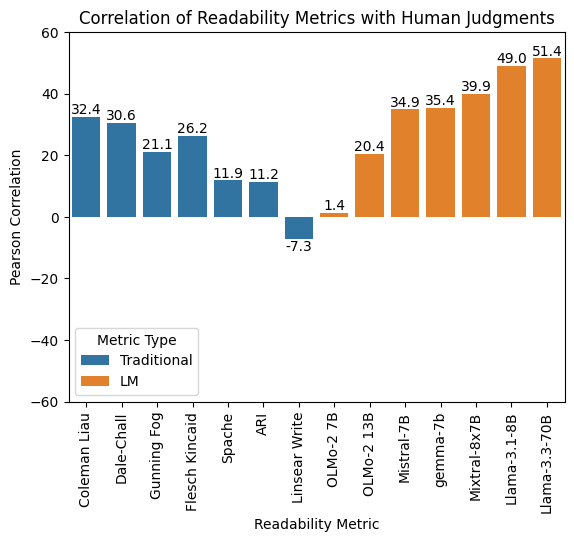

In [28]:
x_labels = [
'Coleman Liau',
 'Dale-Chall',
 'Gunning Fog',
 'Flesch Kincaid',
 'Spache',
 'ARI',
 'Linsear Write',
 'OLMo-2 7B',
 'OLMo-2 13B',
 'Mistral-7B',
 'gemma-7b',
 'Mixtral-8x7B',
 'Llama-3.1-8B',
 'Llama-3.3-70B'
]
hue = ["Traditional"]*7 + ["LM"]*7
plot_df = pd.DataFrame.from_dict(
    {
        "Pearson Correlation":all_correlations_pearson[:,0]*100,
        "Readability Metric": x_labels,
        "Metric Type": hue
    }
    )

# ax.set_xticklabels(labels=x_labels, rotation=45)
ax = sns.barplot(plot_df, x="Readability Metric", y="Pearson Correlation", hue="Metric Type")
plt.rcParams["figure.figsize"] = (12,4)
ax.tick_params(axis='x', rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%.01f')
plt.ylim(-60, 60)
plt.title("Correlation of Readability Metrics with Human Judgments")
plt.show()

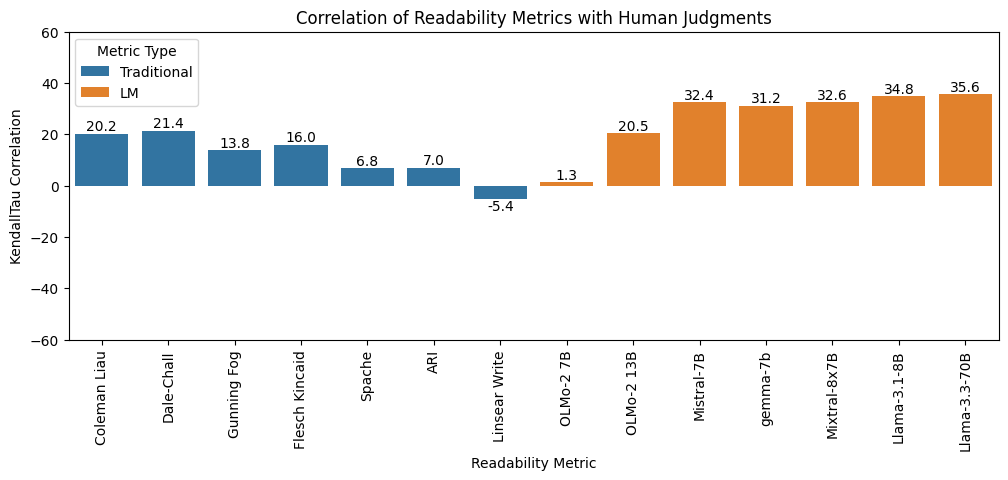

In [29]:
x_labels = [
'Coleman Liau',
 'Dale-Chall',
 'Gunning Fog',
 'Flesch Kincaid',
 'Spache',
 'ARI',
 'Linsear Write',
 'OLMo-2 7B',
 'OLMo-2 13B',
 'Mistral-7B',
 'gemma-7b',
 'Mixtral-8x7B',
 'Llama-3.1-8B',
 'Llama-3.3-70B'
]
hue = ["Traditional"]*7 + ["LM"]*7
plot_df = pd.DataFrame.from_dict(
    {
        "KendallTau Correlation":all_correlations_kt[:,0]*100,
        "Readability Metric": x_labels,
        "Metric Type": hue
    }
    )

# ax.set_xticklabels(labels=x_labels, rotation=45)
ax = sns.barplot(plot_df, x="Readability Metric", y="KendallTau Correlation", hue="Metric Type")
plt.rcParams["figure.figsize"] = (12,4)
ax.tick_params(axis='x', rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%.01f')
plt.ylim(-60, 60)
plt.title("Correlation of Readability Metrics with Human Judgments")
plt.show()

In [30]:
hue = []
vals = []
for _, row in clean_summ_df.iterrows():
  for m_name in all_model_names:
    hue.append(m_name)
    vals.append(row[f'r-{m_name}'])
  hue.append('reading_ease')
  vals.append(row['s-article_read_ease'])
df_val_dist = pd.DataFrame({"val_name": hue, "val": vals})
df_val_dist

,val_name,val
0,OLMo-2-1124-7B-Instruct_prompt4,4.000000
1,OLMo-2-1124-13B-Instruct_prompt4,4.000000
2,Mistral-7B-Instruct-v0.3_prompt4,3.500000
3,gemma-7b-it_prompt4,3.000000
4,Mixtral-8x7B-Instruct-v0.1_prompt4,4.000000
...,...,...
1435,gemma-7b-it_prompt4,3.000000
1436,Mixtral-8x7B-Instruct-v0.1_prompt4,3.000000
1437,Llama-3.1-8B-Instruct_prompt4,3.000000
1438,Llama-3.3-70B-Instruct_prompt4,3.000000


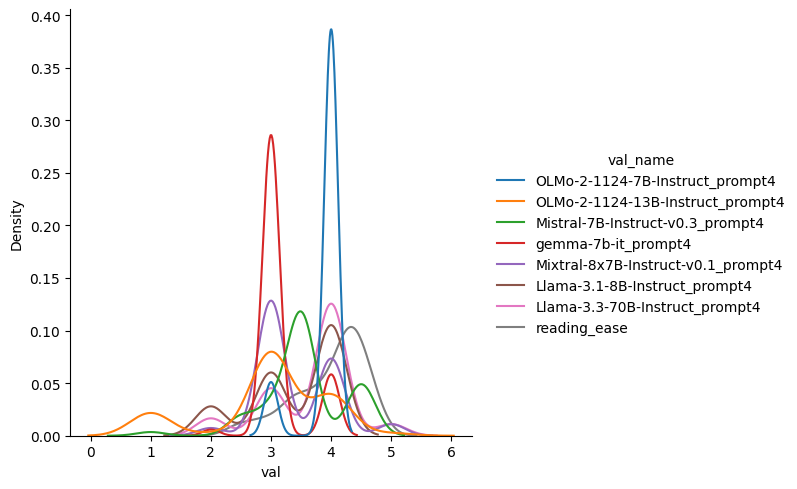

In [61]:
sns.displot(df_val_dist, x='val', hue='val_name', kind="kde")

In [31]:
df_val_dist[df_val_dist['val_name'] == 'reading_ease']

,val_name,val
7,reading_ease,4.043478
15,reading_ease,4.250000
23,reading_ease,3.157895
31,reading_ease,4.043478
39,reading_ease,4.250000
...,...,...
1407,reading_ease,3.850000
1415,reading_ease,4.210526
1423,reading_ease,4.461538
1431,reading_ease,3.850000


## Cohen's Kappa

In [62]:
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm

In [63]:
# Calculate inner annotator agreement
def aggreement_per_annotator(df, annotator_id, metric_name):
  annotator_df = df[df["uuid"]==annotator_id]
  paper_ids = annotator_df['paperId'].unique()
  scores = []
  for pid in paper_ids:
    paper_df = df[df['paperId']==pid]
    y2 = []
    this_annotator_val = annotator_df[annotator_df['paperId']==pid][metric_name].iloc[0]
    this_annotator_val = 1 if this_annotator_val > 3 else 0
    for _, row in paper_df.iterrows():
      if row['uuid'] != annotator_id:
        val = row[metric_name]
        y2.append(1 if val > 3 else 0)
    y2 = np.array(y2)
    y1 = np.full_like(y2, this_annotator_val)
    same = sum(y1==y2)
    scores.append(same/len(y1))

  return np.mean(scores)

In [64]:
aggreement_per_annotator(survey_df, '346a567a-78f4-444f-8a35-00a00efc9324', 'article_read_ease')

0.7634293103533906

In [65]:
def aggreement_per_attr(attr):
  n_annotators = len(survey_df['uuid'].unique())
  this_attr = []
  for i, annotator_id in enumerate(survey_df['uuid'].unique()):
    if i % 100 == 0:
      print(f'{i}/{n_annotators}')
    annotator_score = aggreement_per_annotator(survey_df, annotator_id, attr)
    this_attr.append(annotator_score)
  return this_attr

In [66]:
attr_names

['article_read_ease',
 'article_understanding',
 'article_interest',
 'valuable_info']

In [67]:
article_read_ease_aggreement = aggreement_per_attr('article_read_ease')
np.mean(article_read_ease_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.6000919589431635

In [68]:
article_understanding_aggreement = aggreement_per_attr('article_understanding')
np.mean(article_understanding_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.6070411441150764

In [69]:
article_interest_aggreement = aggreement_per_attr('article_interest')
np.mean(article_interest_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.5262433625510443

In [70]:
valuable_info_aggreement = aggreement_per_attr('valuable_info')
np.mean(valuable_info_aggreement)

0/593
100/593
200/593
300/593
400/593
500/593


0.5787217490422268

## Control for demographics

In [71]:
survey_df[survey_df['uuid']=='346a567a-78f4-444f-8a35-00a00efc9324']

,Unnamed: 0,uuid,science_interest,age,gender,retake,language,education,stemEducation,researchInvolved,...,complexityLevel,order,paperId,stemEducationMapped,eduMapped,relevantInterest,isHighStem,study,generated_free_text,generated_text_check
0,0,346a567a-78f4-444f-8a35-00a00efc9324,15.0,33,0,0,English,College,1-3,no,...,Medium,1,redditCommentsVideoGames,1,1,3.0,False,1,NaN,NaN
1,1,346a567a-78f4-444f-8a35-00a00efc9324,15.0,33,0,0,English,College,1-3,no,...,original,2,redditCommentsExercise,1,1,2.0,False,1,NaN,NaN
2,2,346a567a-78f4-444f-8a35-00a00efc9324,15.0,33,0,0,English,College,1-3,no,...,Low,3,redditCommentsMexicoCity,1,1,2.0,False,1,NaN,NaN


In [72]:
def bin_science_interest(val):
  if val > 10:
    return 2
  if val > 5:
    return 1
  return 0
survey_df['science_interest_binned'] = survey_df['science_interest'].apply(bin_science_interest)

In [73]:
def aggreement_per_annotator_per_dem(df, annotator_id, metric_name, dem_col):
  annotator_df = df[df["uuid"]==annotator_id]
  annotator_dem = annotator_df[dem_col].iloc[0]
  paper_ids = annotator_df['paperId'].unique()
  scores = []
  for pid in paper_ids:
    paper_df = df[df['paperId']==pid]
    paper_df = paper_df[paper_df[dem_col]==annotator_dem]
    y2 = []
    this_annotator_val = annotator_df[annotator_df['paperId']==pid][metric_name].iloc[0]
    this_annotator_val = 1 if this_annotator_val > 3 else 0
    for _, row in paper_df.iterrows():
      if row['uuid'] != annotator_id:
        val = 1 if row[metric_name] > 3 else 0
        y2.append(val)
    if len(y2) > 0:
      y2 = np.array(y2)
      y1 = np.full_like(y2, this_annotator_val)
      same = sum(y1==y2)
      scores.append(same/len(y1))
  if len(scores) == 0:
    return None
  return np.mean(scores)

def aggreement_per_attr_per_dem(attr, dem):
  n_annotators = len(survey_df['uuid'].unique())
  this_attr = []
  n_annotators_excl = 0
  for i, annotator_id in enumerate(survey_df['uuid'].unique()):
    if i % 100 == 0:
      print(f'{i}/{n_annotators}')
    annotator_score = aggreement_per_annotator_per_dem(survey_df, annotator_id, attr, dem)
    if annotator_score is not None:
      this_attr.append(annotator_score)
    else:
      n_annotators_excl += 1
  print(f"{n_annotators_excl}/{n_annotators} annotators excluded.")
  return this_attr

In [74]:
article_read_ease_agg_per_dem = aggreement_per_attr_per_dem('article_read_ease', 'science_interest_binned')
np.mean(article_read_ease_agg_per_dem)

0/593
100/593
200/593
300/593
400/593
500/593
0/593 annotators excluded.


0.6066938378196906

In [75]:
article_read_ease_agg_per_dem = aggreement_per_attr_per_dem('article_read_ease', 'education')
np.mean(article_read_ease_agg_per_dem)

0/593
100/593
200/593
300/593
400/593
500/593
1/593 annotators excluded.


0.6014537789311311

In [76]:
article_read_ease_agg_per_dem = aggreement_per_attr_per_dem('article_read_ease', 'stemEducation')
np.mean(article_read_ease_agg_per_dem)

0/593
100/593
200/593
300/593
400/593
500/593
0/593 annotators excluded.


0.5964263324016073

In [77]:
article_read_ease_agg_per_dem = aggreement_per_attr_per_dem('article_read_ease', 'age')
np.mean(article_read_ease_agg_per_dem)

0/593
100/593
200/593
300/593
400/593
500/593
10/593 annotators excluded.


0.6235531509974048

# Krippendorff’s Alpha

In [78]:
attr = 'article_read_ease'
annotators = survey_df['uuid'].unique()
papers = survey_df['paperId'].unique()
reliability_data = np.full((len(papers), len(annotators)), np.nan)
for i, uuid in enumerate(annotators):
  for j, pid in enumerate(papers):
    tmp = survey_df[survey_df['uuid']==uuid]
    tmp = tmp[tmp['paperId'] == pid]
    if len(tmp) > 0:
      val = tmp[attr].iloc[0]
      reliability_data[j,i] = val

In [79]:
reliability_data

array([[ 5., nan, nan, ...,  5.,  5., nan],
       [ 5., nan, nan, ..., nan,  5., nan],
       [ 4.,  5.,  4., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [80]:
% pip install krippendorff
import krippendorff

UsageError: Line magic function `%` not found.


In [ ]:
krippendorff.alpha(reliability_data=reliability_data)

In [ ]:
survey_df.columns

In [ ]:
survey_df['science_interest'].value_counts()